In [ ]:
!ls

gas_network_works_info.csv  sample_data


# Practical assignment №1. Industrial processes scheduling using the SAMPO framework

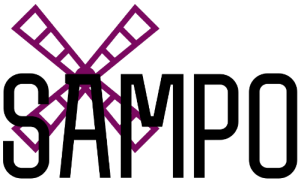

In this practical assignment, you will create for solving industrial processes schedule optimization task for synthetically generated graph structure, which simulates the real industrial projects' data, and for the actual project in the area of gas and oil field development.

In both cases, you will configure classic scheduling pipelines and tune the parameters of the genetic scheduler to solve the makespan variation of the schedule's optimization most efficiently.

Link to the repository with the code, documentation, and examples: https://github.com/aimclub/SAMPO. You can get additional information about the framework from here.

In [1]:
# Install the stable version of the sampo package
# Don't forget to restart the runtime in order to use newly installed versions of packages!
!pip install sampo==0.1.1.221

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.1/187.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.2/317.2 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
  Attempting uninstall: pytest
 

In [2]:
# Write your code for importing libraries here
from itertools import chain
from sampo.utilities.visualization.work_graph import work_graph_fig
from sampo.utilities.visualization.base import VisualizationMode

from sampo.generator.base import SimpleSynthetic
from sampo.generator.types import SyntheticGraphType

from sampo.generator.environment.contractor_by_wg import get_contractor_by_wg, ContractorGenerationMethod

from sampo.scheduler.heft.base import HEFTScheduler, HEFTBetweenScheduler
from sampo.scheduler.genetic.base import GeneticScheduler

from sampo.pipeline import SchedulingPipeline
from sampo.utilities.visualization.schedule import schedule_gant_chart_fig

Can not find native module; switching to default


## 1. Schedule time optimization on synthetic graphs

In this part of the task, you will:
* create the synthetically generated graph structure, which simulates the real industrial tasks' structure;
* configure contractors for executing these tasks;
* set up the different types of schedulers to create schedules, which will be optimal in terms of time to complete all project tasks;
* configure scheduling pipelines;
* visualize final schedules.

### 1.1 Synthetic WorkGraph object creation

Create the synthetic WorkGraph object in `GENERAL` mode.

Resulted graph should contain 3 clusters, with the bottom border of total project works' number = 200 and the top border = 500.

Use `seed=21` for the graph generation.


In [ ]:
wg_seed=21

# Write your code for the synthetic Work Graph object creation here
nazi_ss = SimpleSynthetic(wg_seed)

general_wg = nazi_ss.work_graph(
    mode=SyntheticGraphType.GENERAL,
    cluster_counts=3,   # - number of clusters for the graph
    bottom_border=200,  # - bottom border for number of works for the graph
    top_border=500,     # - top border for number of works for the graph
)

Visualize the structure of the created WorkGraph and answer the following questions:
1. What is the total number of works in the created graph?
2. What is the total number of connections between the works in the created graph?
3. What is the maximum number of successors the works in the constructed graph have?

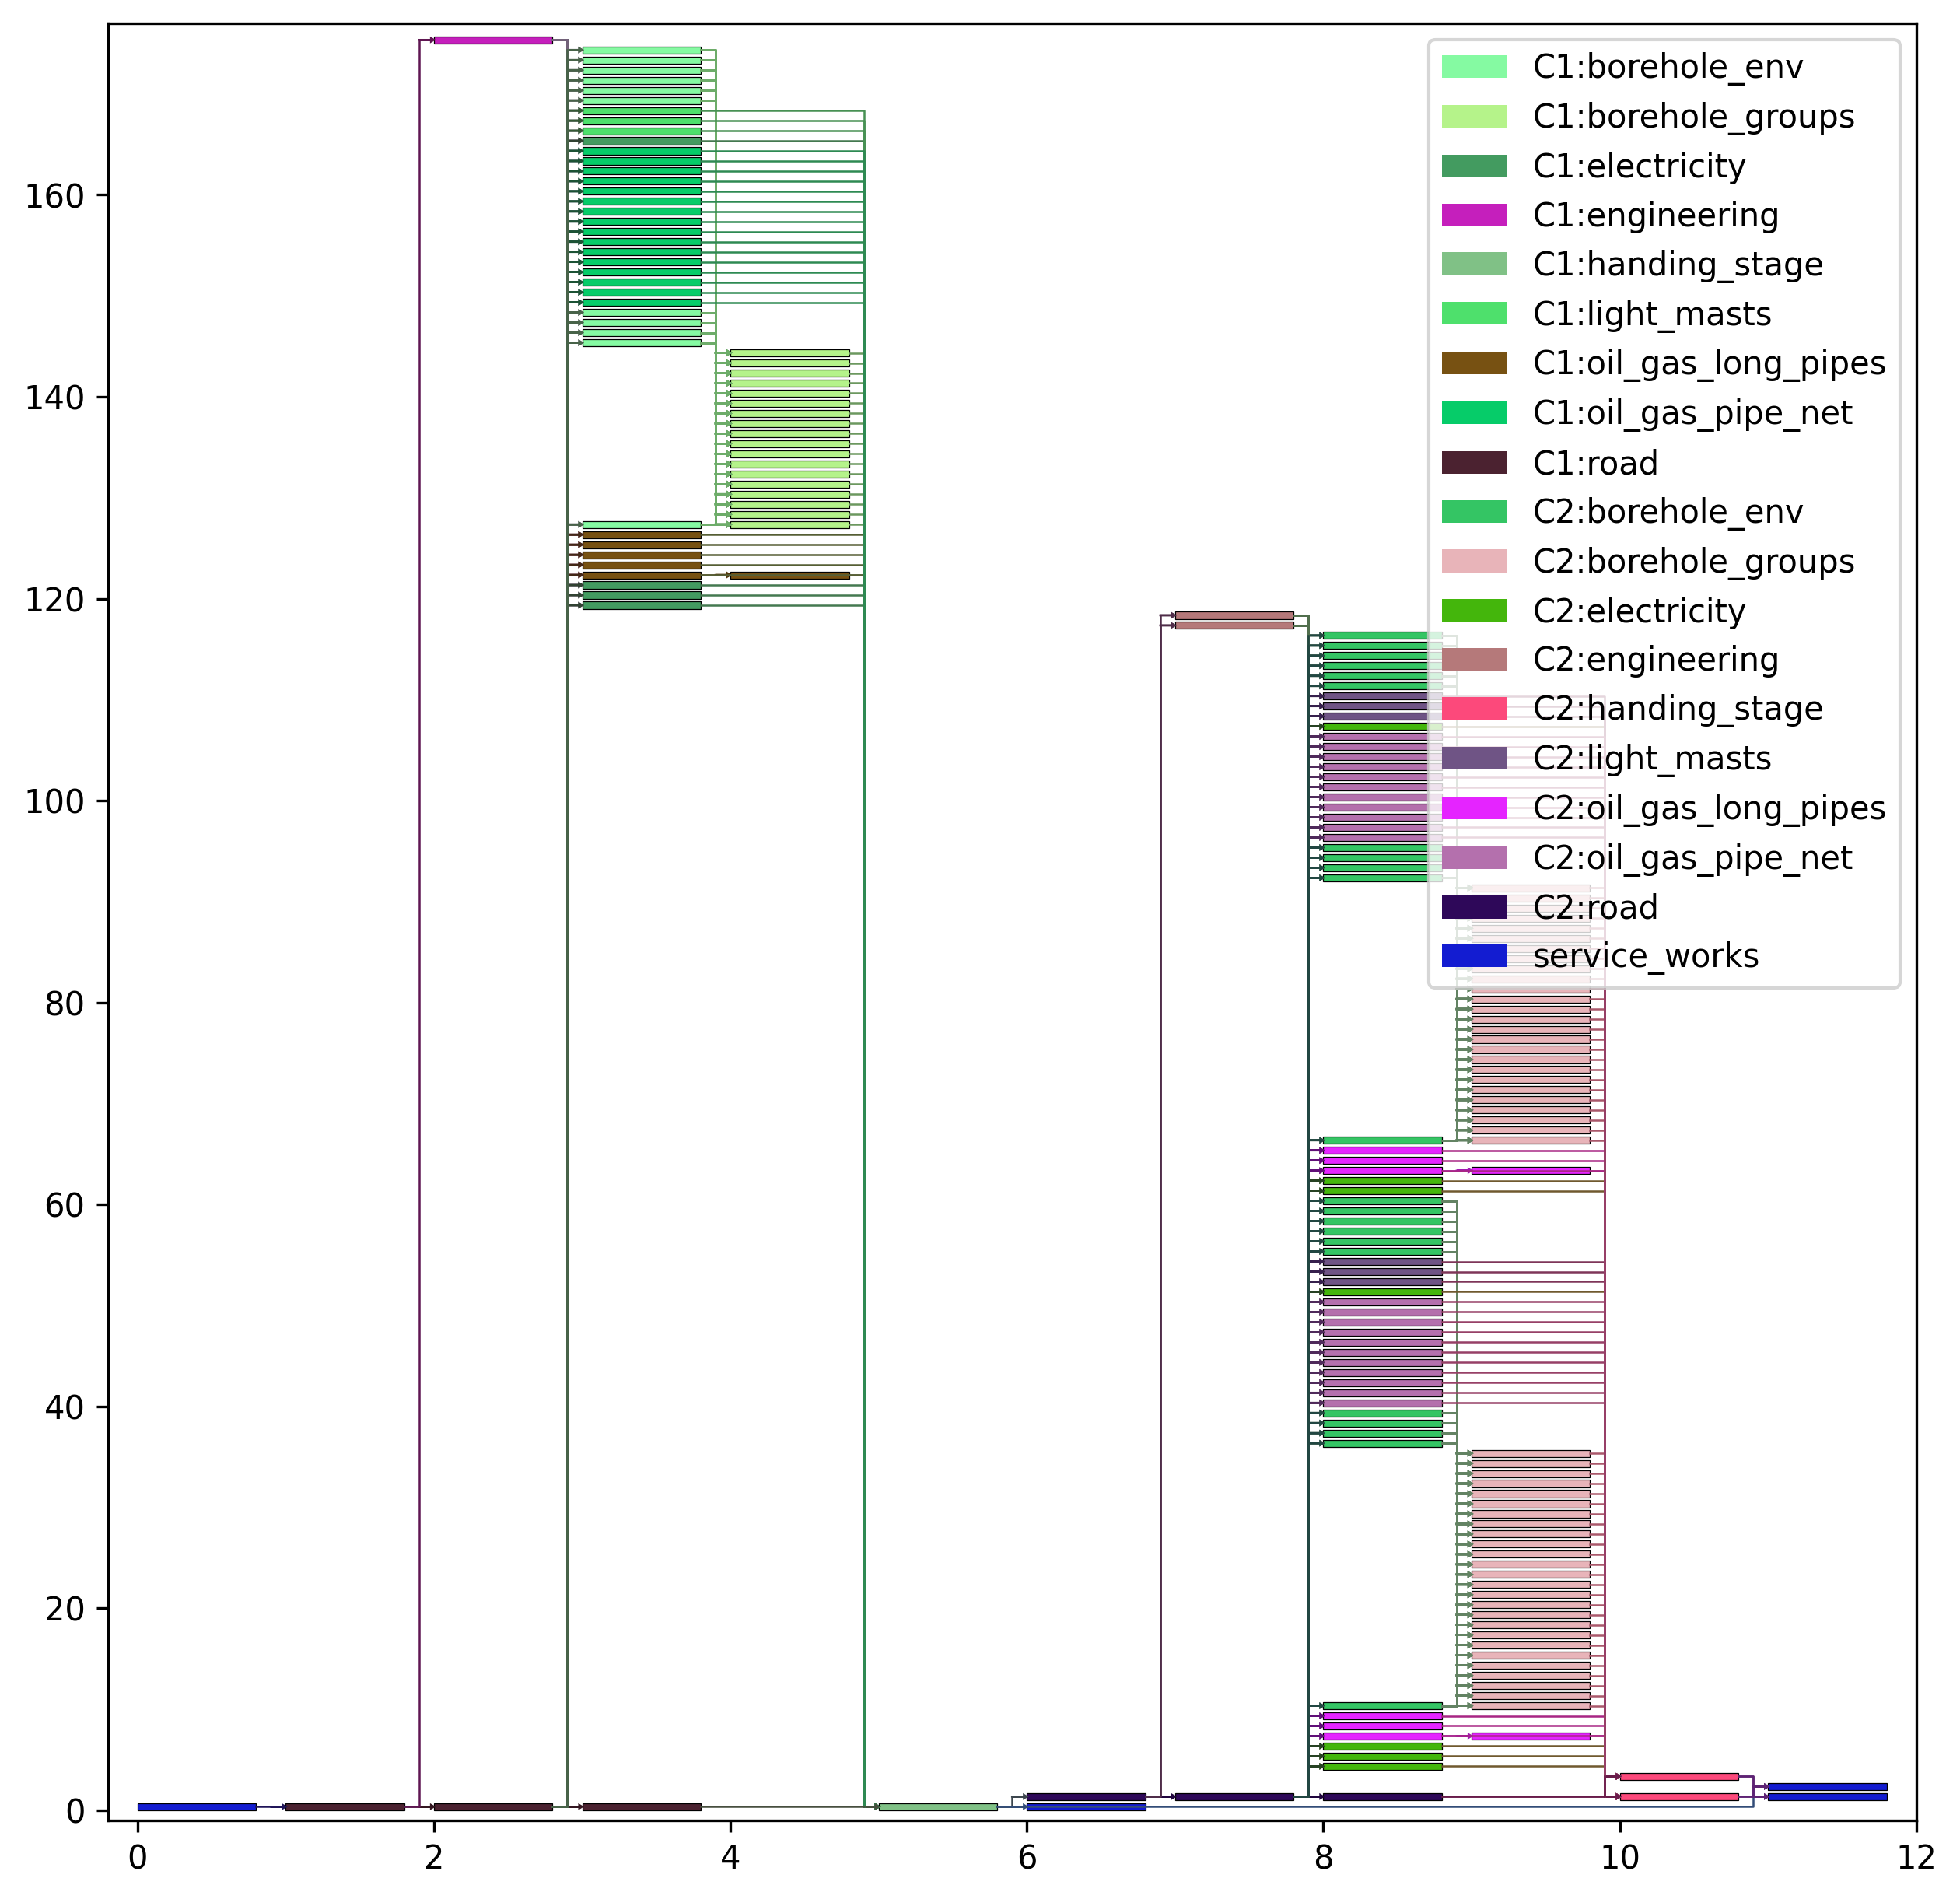

In [ ]:
fig_size = (10, 4) # use this value as the attribute in visualization

# Write your code for the graph's visualization here
general_wg_fig = work_graph_fig(
    general_wg,
    (10, 10),
)

general_wg_fig.show()

In [ ]:
# Write your code for calculating the number of works in the generated WorkGraph here
works_count = general_wg.vertex_count

# Write your code for calculating the number of connections between the works here
connections = len(general_wg.adj_matrix)

# Write your code for calculating the maximum number of successors for works in the generated WorkGraph
succ = 0
for edge in general_wg.dict_nodes:
    # print(general_wg.dict_nodes.get(edge).edges_from)
    succ += len(general_wg.dict_nodes.get(edge).edges_from) # TODO

print(f"Number of works:{works_count}\nNumber of connections:{connections}\nMaximum successors: {succ}")

Number of works:191
Number of connections:926
Maximum successors: 927


Write your answers bellow:

1. -
2. -
3. -

### 1.2 Contractors' creation

Create lists of two contractors to execute the works from the generated WorkGraph object.

Use the function to get the contractor from the work graph and `MIN` and `AVG` generation modes.

In [ ]:
# Write your code for contractors creation here
contractors_for_general_wg = [
    get_contractor_by_wg(
        general_wg,
        method=ContractorGenerationMethod.AVG)
]


    # Contractor(id="OOO Shiter", workers=[Worker(id='0', kind='general', count=100)]),
    # Contractor(id="OOO Pisser", workers=[Worker(id='1', kind='general', count=100)]),

### 1.3 Initializing and configuring the schedulers

Initialize three types of schedulers (Genetic, HEFT, and HEFTBetween) and configure the Genetic scheduler's attributes to solve the total schedule time minimization task most effectively.

**Note:** Schedule time minimization is the default optimization metric for all schedulers

In [ ]:
# Write your code for the genetic scheduler's hyperparameter tuning here
GENERATIONS = 50
MUTATE_ORDER = 0.05
MUTATE_RESOURCES=0.005
SIZE_OF_POPULATION=50

In [ ]:
# Initialize meta-heuristic and genetic schedulers
HEFTAddEnd_scheduler = HEFTScheduler()
HEFTAddBetween_scheduler = HEFTBetweenScheduler()
genetic_scheduler = GeneticScheduler()

### 1.4 Configuring scheduling pipeline

Create `SchedulingPipeline` object, pass the prepared data about graph structure, contractors, and schedulers to it, and build three schedules for three types of schedulers.

In [ ]:
# Write your code for creating SchedulingPipeline objects and generating schedules for all schedulers' types
general_wg_genetic_schedule = SchedulingPipeline\
    .create() \
    .wg(general_wg) \
    .contractors(contractors_for_general_wg) \
    .schedule(genetic_scheduler) \
    .finish()


general_wg_HEFT_schedule = SchedulingPipeline\
    .create() \
    .wg(general_wg) \
    .contractors(contractors_for_general_wg) \
    .schedule(HEFTAddEnd_scheduler) \
    .finish()

general_wg_HEFTBetween_schedule = SchedulingPipeline\
    .create() \
    .wg(general_wg) \
    .contractors(contractors_for_general_wg) \
    .schedule(HEFTAddBetween_scheduler) \
    .finish()

Genetic optimizing took 115.69094657897949 ms
Toolbox initialization & first population took 6427.345037460327 ms
First population evaluation took 2516.7157649993896 ms
-- Generation 1, population=50, best fitness=1685.0 --
-- Generation 2, population=50, best fitness=1555.0 --
-- Generation 3, population=50, best fitness=1555.0 --
-- Generation 4, population=50, best fitness=1555.0 --
-- Generation 5, population=50, best fitness=1555.0 --
-- Generation 6, population=50, best fitness=1532.0 --
-- Generation 7, population=50, best fitness=1532.0 --
-- Generation 8, population=50, best fitness=1532.0 --
-- Generation 9, population=50, best fitness=1532.0 --
-- Generation 10, population=50, best fitness=1532.0 --
-- Generation 11, population=50, best fitness=1532.0 --
-- Generation 12, population=50, best fitness=1510.0 --
-- Generation 13, population=50, best fitness=1510.0 --
-- Generation 14, population=50, best fitness=1487.0 --
-- Generation 15, population=50, best fitness=1487.0 --


### 1.5 Visualization of the resulting schedule

Visualize the Gantt charts for the best schedules for all three WorkGraphs.  

Use the `ShowFig` visualization mode and the value of the attribute `remove_service_tasks=False`

In [ ]:
# Write your code for schedules' visualizations here
# Do not forget to add the stages merging process for the better visualization and setup the start date
genetic_merged_schedule = general_wg_genetic_schedule.merged_stages_datetime_df("2023-10-21")

genetic_fig = schedule_gant_chart_fig(
    schedule_dataframe=genetic_merged_schedule,
    visualization=VisualizationMode.ShowFig
)

In [ ]:
HEFT_merged_schedule = general_wg_HEFT_schedule.merged_stages_datetime_df("2023-10-21")

HEFT_fig = schedule_gant_chart_fig(
    schedule_dataframe=HEFT_merged_schedule,
    visualization=VisualizationMode.ShowFig
)

In [ ]:
HEFTBetween_merged_schedule = general_wg_HEFTBetween_schedule.merged_stages_datetime_df("2023-10-21")

HEFTBetween_fig = schedule_gant_chart_fig(
    schedule_dataframe=HEFTBetween_merged_schedule,
    visualization=VisualizationMode.ShowFig
)

## 2. Schedule time optimization on the graph of a real industrial project

The file `gas_network_works_info.csv` contains information on the structure of works in the project for the installation of gas distribution networks in the field. Create a WorkGraph object based on it and build a complete planning pipeline to obtain a schedule that optimizes all works' completion time.

The choice of scheduler type and hyperparameter settings is left to your discretion.

In [3]:
# Write your code for creating WorkGraph, configuring scheduling pipeline and visualizing the results of scheduling bellow (free-form)

"""
    Creating scheduling pipeline with the automatic WorkGraph object generation from the given file.
    If you haven't got the historical data,
    change_base_on_history parameter schould be set to False and
    is_wg_has_full_info_about_connections parameter schould be set to True
"""

def getSchizophreniaFigure(sucker_some_dicker):
    schizophrenia = SchedulingPipeline\
        .create() \
        .wg(
            wg="gas_network_works_info.csv",
            is_wg_has_full_info_about_connections=True,
            change_base_on_history=False) \
        .schedule(sucker_some_dicker) \
        .finish()

    # here we shit ourselves and decide to learn Rust + Zig
    # an interactive HTML form with all info about scheduled works
    merged_schizophrenia = schizophrenia.merged_stages_datetime_df("2023-10-21")

    fig_schizophrenia = schedule_gant_chart_fig(
        schedule_dataframe=merged_schizophrenia,
        visualization=VisualizationMode.ShowFig
    )

In [4]:
getSchizophreniaFigure(HEFTScheduler())

In [5]:
getSchizophreniaFigure(HEFTBetweenScheduler())

In [6]:
getSchizophreniaFigure(GeneticScheduler())

Genetic optimizing took 14.563560485839844 ms
Toolbox initialization & first population took 819.5655345916748 ms
First population evaluation took 928.6983013153076 ms
-- Generation 1, population=50, best fitness=5.0 --
-- Generation 2, population=50, best fitness=5.0 --
-- Generation 3, population=50, best fitness=5.0 --
-- Generation 4, population=50, best fitness=5.0 --
-- Generation 5, population=50, best fitness=5.0 --
-- Generation 6, population=50, best fitness=5.0 --
-- Generation 7, population=50, best fitness=5.0 --
-- Generation 8, population=50, best fitness=5.0 --
-- Generation 9, population=50, best fitness=5.0 --
-- Generation 10, population=50, best fitness=4.0 --
-- Generation 11, population=50, best fitness=4.0 --
-- Generation 12, population=50, best fitness=4.0 --
-- Generation 13, population=50, best fitness=4.0 --
-- Generation 14, population=50, best fitness=4.0 --
-- Generation 15, population=50, best fitness=4.0 --
-- Generation 16, population=50, best fitness=